<a href="https://colab.research.google.com/github/jbEmanuel/Machine_Course/blob/main/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROJECTO FINAL DO MODULO DE** **MACHINE** **LEARNING** 

# leitura das Bibliotecas e outras Dependencias

In [ ]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from itertools import combinations 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics as skmetrics
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# 1. Source

## Standard Scaler

In [ ]:
# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

#Standard Scaler 
def standard_scaler(X_train, X_test):
    stdc = StandardScaler()
    X_train_std = stdc.fit_transform(X_train)
    X_test_std = stdc.transform(X_test)
    return X_train_std, X_test_std


## Metrics

In [ ]:
def metric(y_test, y_pred):     
    _auc = skmetrics.roc_auc_score(y_test,y_pred)
    _accuracy = skmetrics.accuracy_score(y_test, y_pred)
    _f1 = skmetrics.f1_score(y_test,y_pred)
    _recall = skmetrics.recall_score(y_test,y_pred)
    _precision = skmetrics.precision_score(y_test,y_pred)
    _logloss = skmetrics.log_loss(y_test,y_pred)
    print('F1:', _f1)
    print('AUC:', _auc)
    print('Test accuracy:', _accuracy)
    print('Recall:', _recall)
    print('Precision:', _precision)
    print('Logloss:', _logloss)
    

## Plots Functions

In [ ]:
def plot_confusion_matrix(y_test, y_pred):    
    # get confusion matrix from sklearn
    cm = metrics.confusion_matrix(y_test, y_pred)
    # plot using matplotlib and seaborn
    plt.figure(figsize=(10, 10))
    cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0,
    as_cmap=True)
    sns.set(font_scale=2.5)
    sns.heatmap(cm, annot=True, cmap=cmap, cbar=False)

def plot_precision_recall_vs_threshold(y_train, y_scores):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

## Feature Selection Classes and Functions

### Random Forrest Feature Selection

In [ ]:
class RFFS():
    def __init__(self, X, y, col_names):
        self.X = X
        self.y = y
        self.col_names = col_names

#X_train,y_train,X_test,y_test = train_test_split(data,test_size=0.3)
    def plot_model(self, n_estimators, random_state = 1):
        model = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
        # fit the model
        model.fit(self.X, self.y)
        importances = model.feature_importances_
        idxs = np.argsort(importances)
        plt.title('Feature Importances')
        plt.barh(range(len(idxs)), importances[idxs], align='center')
        plt.yticks(range(len(idxs)), [self.col_names[i] for i in idxs])
        plt.xlabel('Random Forest Feature Importance')
        plt.show()


### SBS Impllementation

In [ ]:
class SBS():
    def __init__(self, estimator, k_features, scoring= accuracy_score, test_size = 0.25, random_state =1):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test,y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim -1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self 

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score 


### ANOVA Implementation

In [ ]:
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# 2. Leitura dos Dados

## 2.1 Leitura dos dados

In [ ]:
# Teste para adicionar no github

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv")
df.head(n=10)

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
5,49,22.854458,92,3.226,0.732087,6.8317,13.679750,10.31760,530.410,1
6,89,22.700000,77,4.690,0.890787,6.9640,5.589865,12.93610,1256.083,1
7,76,23.800000,118,6.470,1.883201,4.3110,13.251320,5.10420,280.694,1
8,73,22.000000,97,3.350,0.801543,4.4700,10.358725,6.28445,136.855,1
9,75,23.000000,83,4.952,1.013839,17.1270,11.578990,7.09130,318.302,1


### 2.2.1 Change Classification Columns to Object and Binaryze the columns

In [ ]:
binary = {1:1, 2:0}
df.loc[:, "Classification"] = df.Classification.map(binary)
df['Classification'].astype('object')

0      1
1      1
2      1
3      1
4      1
      ..
111    0
112    0
113    0
114    0
115    0
Name: Classification, Length: 116, dtype: object

### 2.2.2 Separar as colunas dos dados das features

In [ ]:
colunas = df.drop(['Classification'], axis = 1).columns
X = df[colunas].values
y = df['Classification'].values

### 2.2.3 Create train and test sets


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state = 1)
X_train_std, X_test_std = standard_scaler(X_train, X_test)

# 3. Feature Selection

## 2.1 Random Forrest Feature Selection

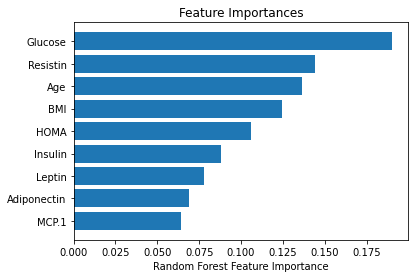

In [ ]:
test = RFFS(X, y, colunas)
test.plot_model(500)

## 2.2 Create data with the best features

In [ ]:
X_rf = df[['Age', 'Resistin', 'Glucose','BMI']].values
X_train_rf, X_test_rf, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state = 1)
X_train_std_rf, X_test_std_rf = standard_scaler(X_train_rf, X_test_rf)

## 2.2 Feature Selection Using ANOVA F-test

Age: 0.027866
BMI: 0.036756
Glucose: 15.253744
Insulin: 9.676861
HOMA: 9.499512
Leptin: 0.469594
Adiponectin: 0.972079
Resistin: 3.541874
MCP.1: 2.122634


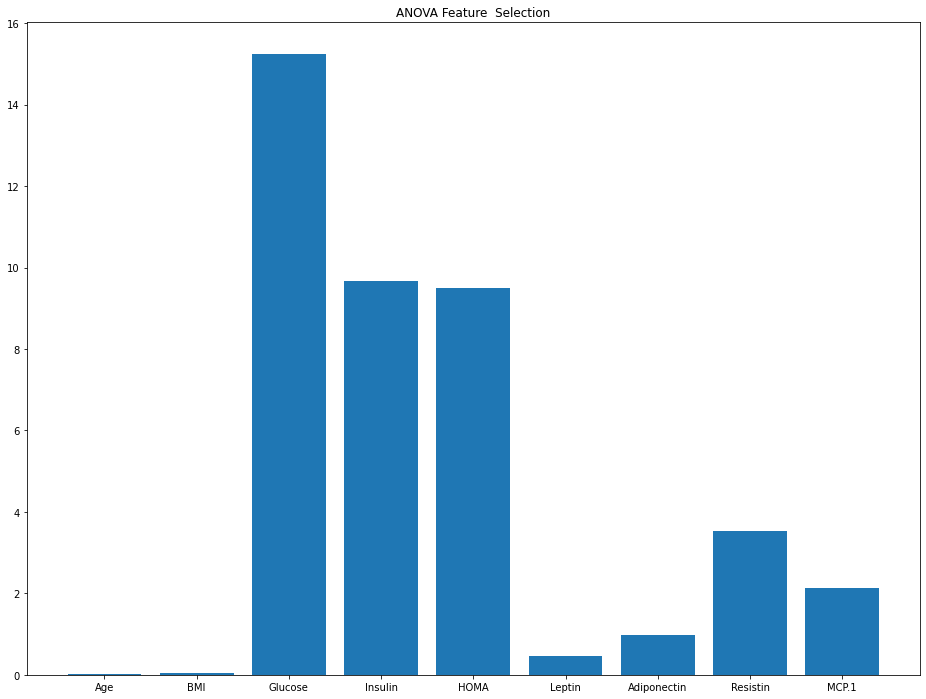

In [ ]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for feature, i in zip(colunas,range(len(fs.scores_))):
	print(f'{feature}: %f' % (fs.scores_[i]))

# plot the scores
fig = plt.figure(figsize = (16, 12))
plt.bar([feature for feature in colunas], fs.scores_)
plt.title("ANOVA Feature  Selection")
plt.show()

## 2.3 Feature Selection using SBS

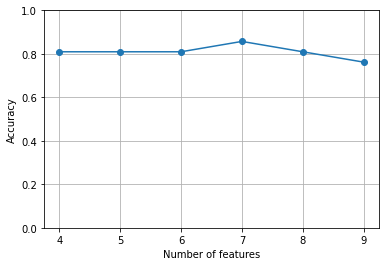

In [ ]:
rfc = RandomForestClassifier(n_estimators = 500, random_state = 1)
sbs = SBS(rfc, k_features= 4)
sbs.fit(X_train, y_train)
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [ ]:
k5 = list(sbs.subsets_[5])
print(df.columns[1:][k5])

Index(['Glucose', 'Insulin', 'HOMA', 'Adiponectin'], dtype='object')


# 4. Classification Models Application

## 4.1 KNN Neighboors

### 3.2.1 KNN Using all features

In [ ]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors

for metric in ('f1', 'accuracy', 'recall', 'precision','roc_auc'):
    knn_gscv = GridSearchCV(knn2, param_grid, cv=10, scoring=str(metric))
    #fit model to data
    knn_gscv.fit(X_train_std, y_train)

    #check top performing n_neighbors value
    print(f'Number of k using {metric} metric: ' ,knn_gscv.best_params_["n_neighbors"])
    print(f'Best score using {metric} metric', knn_gscv.best_score_)

Number of k using f1 metric:  1
Best score using f1 metric 0.6292857142857143
Number of k using accuracy metric:  4
Best score using accuracy metric 0.7152777777777778
Number of k using recall metric:  1
Best score using recall metric 0.6833333333333333


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of k using precision metric:  4
Best score using precision metric 0.8016666666666665
Number of k using roc_auc metric:  4
Best score using roc_auc metric 0.7422916666666667


In [ ]:
final_model = knn_gscv.best_estimator_
y_p = final_model.predict(X_test_std)
final_metric = skmetrics.accuracy_score (y_p, y_test)
print(final_metric)

0.7142857142857143


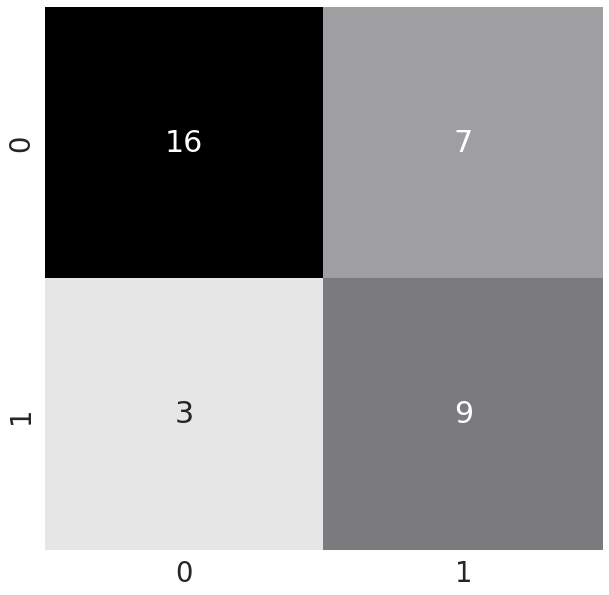

In [ ]:
conf_matrix = plot_confusion_matrix(y_p, y_test)

### 3.2.2 KNN Using Features Resistin, glucose, age and BMI

In [ ]:
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors

for metric in ('f1', 'accuracy', 'recall', 'precision','roc_auc'):
    knn_gscv_rf = GridSearchCV(knn2, param_grid, cv=10, scoring=str(metric))
    #fit model to data
    knn_gscv_rf.fit(X_train_std_rf, y_train)

    #check top performing n_neighbors value
    print(f'Number of k using {metric} metric: ' ,knn_gscv_rf.best_params_["n_neighbors"])
    print(f'Best score using {metric} metric', knn_gscv_rf.best_score_)

Number of k using f1 metric:  1
Best score using f1 metric 0.6292857142857143
Number of k using accuracy metric:  4
Best score using accuracy metric 0.7152777777777778
Number of k using recall metric:  1
Best score using recall metric 0.6833333333333333


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of k using precision metric:  4
Best score using precision metric 0.8016666666666665
Number of k using roc_auc metric:  4
Best score using roc_auc metric 0.7422916666666667


In [ ]:
final_model_rf = knn_gscv_rf.best_estimator_
y_p_rf = final_model_rf.predict(X_test_std_rf)
final_metric_rf = skmetrics.accuracy_score (y_p, y_test)
print(final_metric_rf)

0.7142857142857143


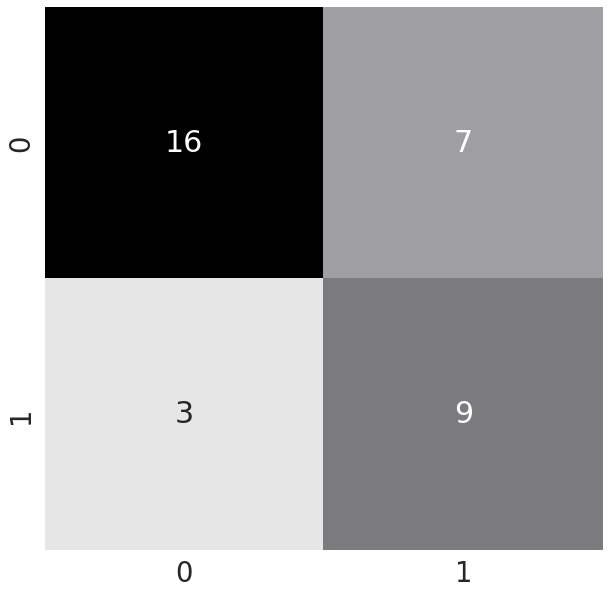

In [ ]:
conf_matrix_rf = plot_confusion_matrix(y_p_rf, y_test)

## 4.2 Logistic Regression

### 4.2.1 Logistic Regression with all features

In [ ]:
#create new a knn model
lr = LogisticRegression()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"C": np.array([1.0, 0.1, 0.001]), "penalty":["l1","l2"], "solver": ["liblinear","saga"]}
#use gridsearch to test all values for n_neighbors

for metric in ('f1', 'accuracy', 'recall', 'precision','roc_auc'):
    lr_gscv = GridSearchCV(lr, param_grid, cv=10, scoring=str(metric))
    #fit model to data
    lr_gscv.fit(X_train_std, y_train)

    #check top performing n_neighbors value
    print(f'Number of C using {metric} metric: {lr_gscv.best_params_["C"]}')
    print(f'Best Solver is: {lr_gscv.best_params_["solver"]}')
    print(f'Best Penalty: {lr_gscv.best_params_["penalty"]}')
    print(f'Best score using {metric} metric', lr_gscv.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Number of C using f1 metric: 0.001
Best Solver is: liblinear
Best Penalty: l2
Best score using f1 metric 0.7043650793650794


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Number of C using accuracy metric: 0.001
Best Solver is: liblinear
Best Penalty: l2
Best score using accuracy metric 0.7152777777777778


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Number of C using recall metric: 0.1
Best Solver is: liblinear
Best Penalty: l1
Best score using recall metric 0.8416666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Number of C using precision metric: 0.001
Best Solver is: liblinear
Best Penalty: l2
Best score using precision metric 0.6616666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Number of C using roc_auc metric: 0.001
Best Solver is: liblinear
Best Penalty: l2
Best score using roc_auc metric 0.7433333333333334


In [ ]:
final_model_lr = lr_gscv.best_estimator_
y_p_lr = final_model_lr.predict(X_test_std)
final_metric_lr = f1_score(y_p_lr, y_test)
print(final_metric_lr)

0.6363636363636364


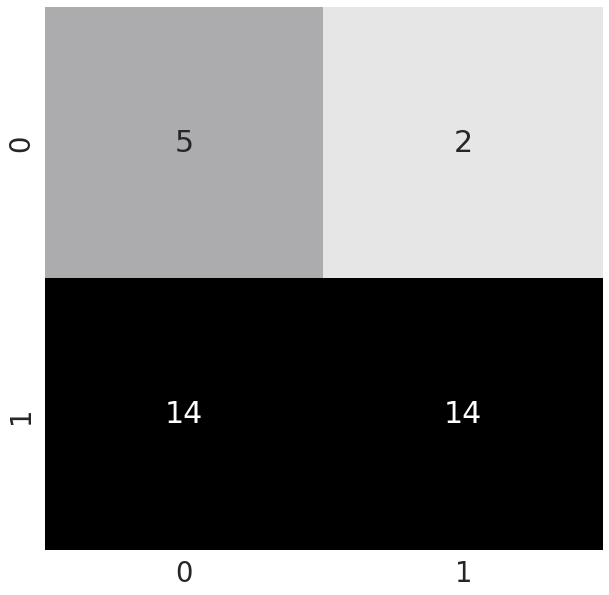

In [ ]:
conf_matrix_lr = plot_confusion_matrix(y_p_lr, y_test)

### 4.2.2 Logistic Regression with Resistin, glucose, age and BMI

In [ ]:
lr = LogisticRegression()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"C": np.array([1.0, 0.1, 0.001]), "penalty":["l1","l2"], "solver": ["liblinear","saga"]}
#use gridsearch to test all values for n_neighbors

for metric in ('f1', 'accuracy', 'recall', 'precision','roc_auc'):
    lr_gscv_rf = GridSearchCV(lr, param_grid, cv=10, scoring=str(metric))
    #fit model to data
    lr_gscv_rf.fit(X_train_std_rf, y_train)

    #check top performing n_neighbors value
    print(f'Number of C using {metric} metric: {lr_gscv_rf.best_params_["C"]}')
    print(f'Best Solver is: {lr_gscv_rf.best_params_["solver"]}')
    print(f'Best Penalty: {lr_gscv_rf.best_params_["penalty"]}')
    print(f'Best score using {metric} metric', lr_gscv_rf.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Number of C using f1 metric: 0.001
Best Solver is: liblinear
Best Penalty: l2
Best score using f1 metric 0.7043650793650794


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Number of C using accuracy metric: 0.001
Best Solver is: liblinear
Best Penalty: l2
Best score using accuracy metric 0.7152777777777778


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Number of C using recall metric: 0.1
Best Solver is: liblinear
Best Penalty: l1
Best score using recall metric 0.8416666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Number of C using precision metric: 0.001
Best Solver is: liblinear
Best Penalty: l2
Best score using precision metric 0.6616666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Number of C using roc_auc metric: 0.001
Best Solver is: liblinear
Best Penalty: l2
Best score using roc_auc metric 0.7433333333333334


In [ ]:
final_model_lr_rf = lr_gscv_rf.best_estimator_
y_p_lr_rf = final_model_lr.predict(X_test_std_rf)
final_metric_lr_rf = f1_score(y_p_lr_rf, y_test)
print(final_metric_lr_rf)

0.6363636363636364


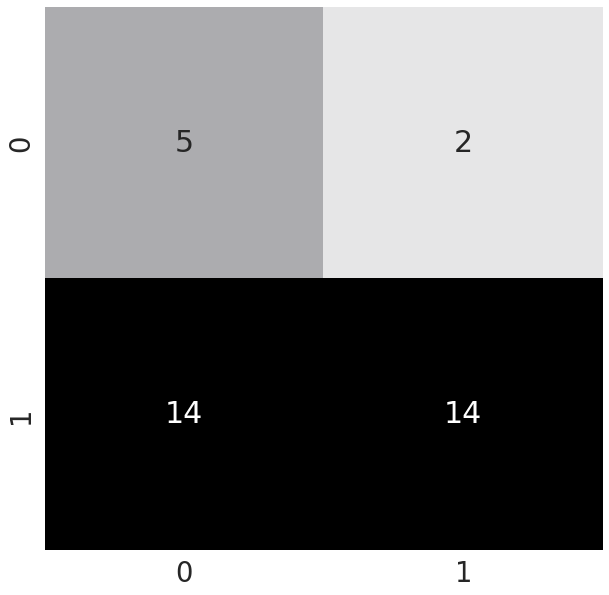

In [ ]:
conf_matrix_lr = plot_confusion_matrix(y_p_lr, y_test)

## 4.3 Decision Trees

## 4.4 SVM

### 4.4.1 SVM with GridSearch Cross-Validation with all features

In [ ]:
model = SVC(random_state=1)
param_range = np.array([0.001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])
param_grid = [{'C': param_range, 'kernel': ['linear']}, 
              {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}]

svm_gscv = GridSearchCV(model , param_grid= param_grid,
                       scoring = 'accuracy', cv = 10, n_jobs= -1)
svm_gscv = svm_gscv.fit(X_train_std, y_train)
print(svm_gscv.best_params_)
print(svm_gscv.best_score_) 

{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.7388888888888889


In [ ]:
clf = svm_gscv.best_estimator_
y_pred_svm = clf.predict(X_test_std)
final_score = accuracy_score(y_pred_svm, y_test)
print(final_score)

0.8


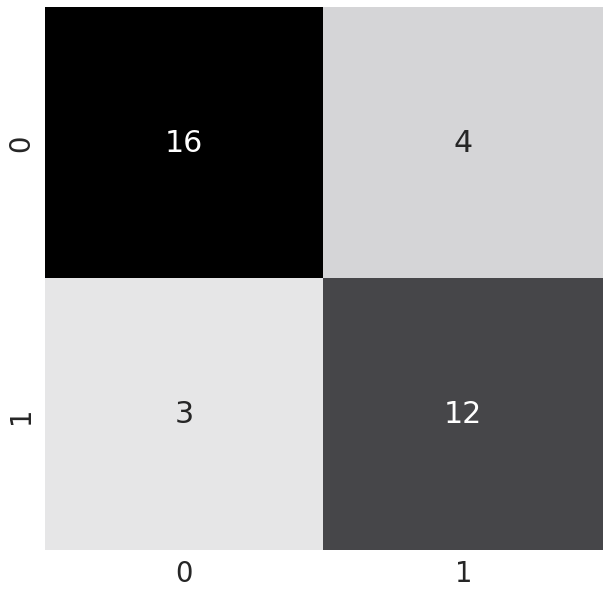

In [ ]:
svm_conf_matrix = plot_confusion_matrix(y_pred_svm, y_test)

### 4.4.2 SVM using Resistin, glucose,  age and BMI

In [ ]:
model = SVC(random_state=1)
param_range = np.array([0.001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])
param_grid = [{'C': param_range, 'kernel': ['linear']}, 
              {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}]

svm_gscv_rf = GridSearchCV(model , param_grid= param_grid,
                       scoring = 'accuracy', cv = 10, n_jobs= -1)
svm_gscv_rf = svm_gscv_rf.fit(X_train_std_rf, y_train)
print(svm_gscv_rf.best_params_)
print(svm_gscv_rf.best_score_) 

{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.7388888888888889


In [ ]:
clf_rf = svm_gscv_rf.best_estimator_
y_pred_svm_rf = clf.predict(X_test_std_rf)
final_score_rf = accuracy_score(y_pred_svm_rf, y_test)
print(final_score_rf)

0.8


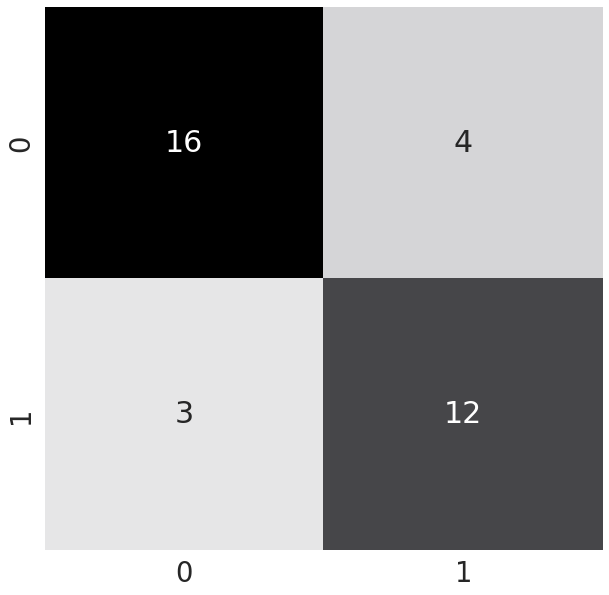

In [ ]:
svm_conf_matrix_rf = plot_confusion_matrix(y_pred_svm_rf, y_test)

## 4.5 Random Forrests

### 4.5.1 Random Forrest with Gridsearch Cross - Validation with all features

# 5. Majority Voting Ensemble Method

# Conclusion